## Import Statements

In [1]:
import os
import random
import numpy as np
from numpy import where
import matplotlib.pyplot as plt

os.environ["CDF_LIB"] = "/usr/local/lib/cdf/lib/"
import netCDF4 as nc
from spacepy import pycdf
from pyspedas import wind

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from sklearn.svm import OneClassSVM

2022-06-09 16:00:50.713861: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-09 16:00:50.716666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 16:00:50.716674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Various functions

In [2]:
# Constants
e = 1.602176634e-19
m = 9.109383701528e-31
e_0 = 8.854187812813e-12
cons = e/((m*e_0)**.5)/(2*np.pi)

In [3]:
def find_closest_time(time, lst):
    return min(range(len(lst)), 
               key=lambda i: abs(time-lst[i]))

def conv_dens_to_freq(ne):
    assert ne>=0
    return ne**.5 * cons

## Building Model

model = Sequential()
model.add(Conv1D(8, kernel_size=2, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(4))
model.add(Conv1D(16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

In [4]:
model = Sequential()
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPool1D(2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 16)                1

2022-06-09 16:00:51.471698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 16:00:51.471718: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 16:00:51.471731: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-09 16:00:51.471916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importing Data

In [5]:
with nc.Dataset("data/wi_wav_tnr_19950625.nc") as file:
    time = file["tnr_ch1_time"][:]
    freq = file["tnr_ch1_freq"][:]
    spec = file["tnr_ch1_spec"][:]

In [6]:
with pycdf.CDF("data/wi_h0_wav_19950625_v01.cdf") as cdf:
    time2 = [float(x.strftime("%s")) for x in cdf["Epoch"][:]]
    density =  cdf["Ne"][:]

In [7]:
dens = []
for t in time:
    loc = find_closest_time(t, time2)
    dens.append(density[loc])

In [8]:
fpe = list(map(conv_dens_to_freq, dens))

In [9]:
print(np.shape(time), np.shape(np.transpose(spec)), np.shape(fpe))
data_v1 = [[time[i], np.transpose(spec)[i], fpe[i]] for i in range(len(fpe))]

(19419,) (19419, 96) (19419,)


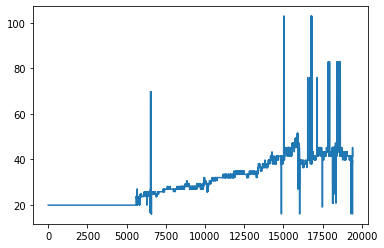

In [10]:
plt.plot(fpe)
# Noticed there were a ton of outliers and messy data, so I decided to remove them from the dataset

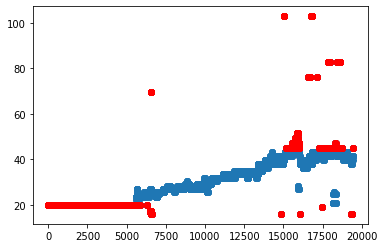

In [11]:
df = np.array(fpe).reshape(-1, 1)
svm_model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.10).fit(df)
y_pred = svm_model.predict(df)
outlier_index = where(y_pred == -1) # filter outlier values
outlier_values = df[outlier_index]
plt.scatter(list(range(len(df))), df)
plt.scatter(outlier_index, outlier_values, c = "r")

In [12]:
data_v2 = [d for d in data_v1 if d[2] > fpe[0] and d[2] < 60]
data_v2[1000:] = [d for d in data_v2[1000:] if d[2] > 30]

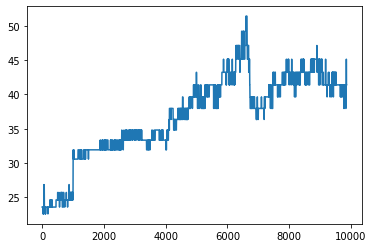

In [13]:
plt.plot([d[2] for d in data_v2])

In [14]:
random.seed(10)
random_index = list(range(len(data_v2)))
random.shuffle(random_index)
data_v3 = list(map(lambda i: data_v2[i], random_index))

In [15]:
for i in range(len(data_v3)):
    for j in range(len(data_v3)):
        if not i == j:
            if data_v3[i][0] == data_v3[j][0]:
                print(i, j)

In [16]:
x_data = np.array([d[1] for d in data_v3])
y_data = np.array([d[2] for d in data_v3])

norm_y = y_data/max(y_data)

s = len(y_data)*9//10
train_x_data, test_x_data = x_data[:s], x_data[s:]
train_y_data, test_y_data = norm_y[:s], norm_y[s:]
test_sorted = data_v3[s:]

test_sorted.sort(key=lambda x: x[0])
test_time_sorted = np.array([d[0] for d in test_sorted])
test_x_sorted = np.array([d[1] for d in test_sorted])
test_y_sorted = np.array([d[2]/max(y_data) for d in test_sorted])

## Training algorithm

In [17]:
model.compile(loss = keras.losses.mean_squared_error, 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [29]:
#model.fit(
#    x=train_x_data, y=train_y_data, epochs=1000, batch_size=5, steps_per_epoch=20,
#    validation_split=0.05, workers=5, use_multiprocessing=True)
model.fit(
    x=train_x_data, y=train_y_data, epochs=200, batch_size=32, steps_per_epoch=10,
    validation_split=.05, workers=10, use_multiprocessing=True)

Epoch 1/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_absolute_percentage_error: 4.2079 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 4.3140
Epoch 2/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_absolute_percentage_error: 4.3248 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 4.2668
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_absolute_percentage_error: 4.1018 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 4.4156
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_absolute_percentage_error: 3.9825 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 4.2098
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_absolute_percentage_error: 3.7483 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 4.2464
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 0.

In [30]:
model.evaluate(test_x_data, test_y_data)

31/31 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_absolute_percentage_error: 3.8159


[0.0012888909550383687, 3.8159477710723877]

31/31 [==============================] - 0s 1ms/step


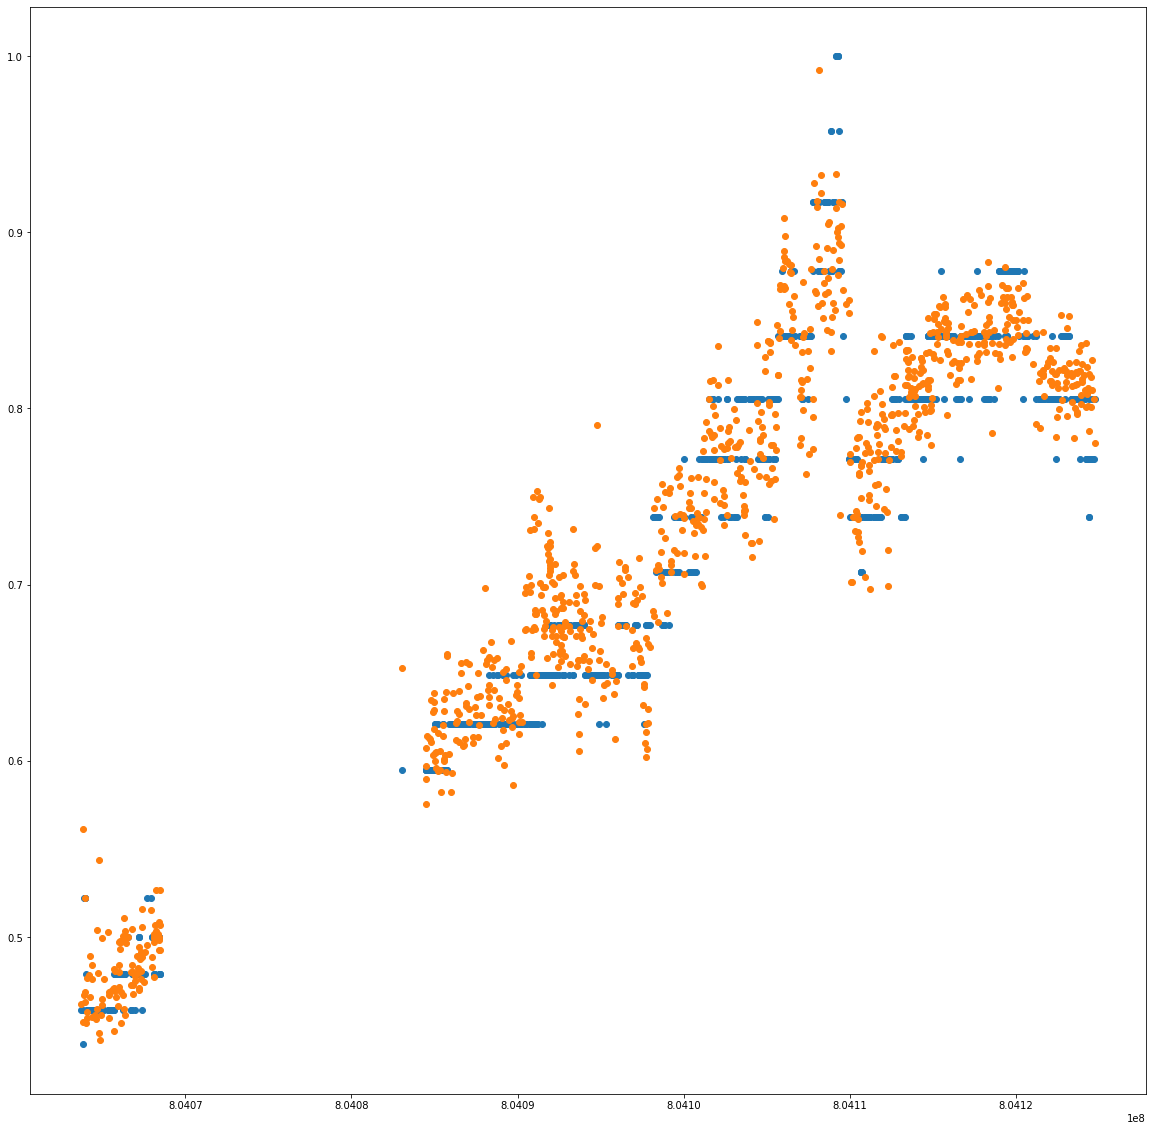

In [31]:
pred_y = model.predict(test_x_sorted)
plt.figure(figsize=(20,20))
plt.scatter(test_time_sorted, test_y_sorted)
plt.scatter(test_time_sorted, pred_y)

In [21]:
freq

masked_array(data=[  4087.58911133,   4268.56201172,   4457.546875  ,
                     4654.89892578,   4860.99023438,   5076.20410156,
                     5300.94677734,   5535.64013672,   5780.72314453,
                     6036.65820312,   6303.92382812,   6583.02197266,
                     6874.47802734,   7178.8359375 ,   7496.67089844,
                     7828.57714844,   8175.17822266,   8537.12402344,
                     8915.09472656,   9309.79882812,   9721.97851562,
                    10152.40722656,  10601.89355469,  11071.27929688,
                    11561.44628906,  12073.31542969,  12607.84765625,
                    13166.04394531,  13748.95507812,  14357.67285156,
                    14993.34179688,  15657.15332031,  16350.35546875,
                    17074.24804688,  17830.18945312,  18619.59765625,
                    19443.95898438,  20304.81445312,  21203.78710938,
                    22142.55859375,  23122.89257812,  24146.63085938,
                    

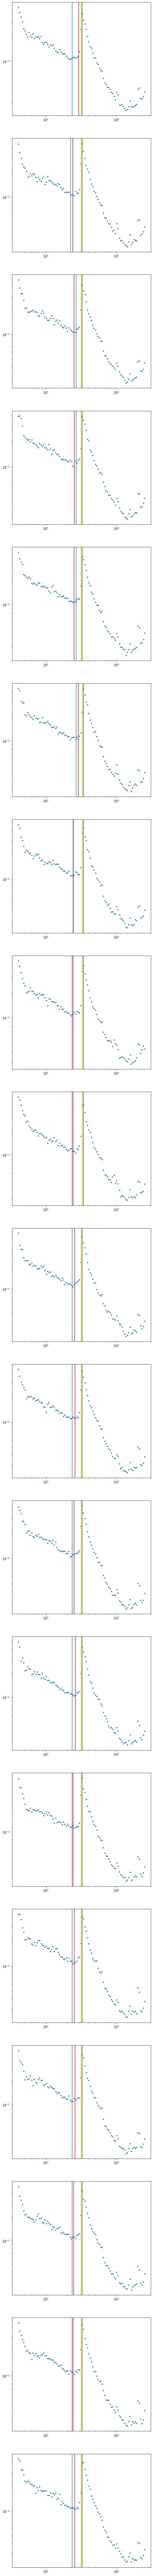

In [22]:
point = 100
n = 20
peakshift = (1 + 8*(1/7.3916)**2)
plt.figure(figsize=(8, 8*20))
for i in range(1, n):
    plt.subplot(n,1, i)
    plt.plot(freq/1000, test_x_sorted[i], 'o', markersize=3, label='WIND data')
    f = freq[max(range(len(freq)), key=lambda x: test_x_sorted[i][x] if freq[x]/1000>10 else 0)]/1000
    plt.axvline(x=f, color='g')
    plt.axvline(x=f-peakshift, color='orange')
    plt.axvline(x=pred_y[i]*max(y_data), color='r')
    plt.axvline(x=test_y_sorted[i]*max(y_data))
    plt.xscale('log')
    plt.yscale('log')
#print(pred_y[point], test_y_sorted[point])
#print(pred_y[point]*max(y_data), test_y_sorted[point]*max(y_data))
#max(pred_y)
plt.show()

In [23]:
max(y_pred)

1

In [24]:
freq

masked_array(data=[  4087.58911133,   4268.56201172,   4457.546875  ,
                     4654.89892578,   4860.99023438,   5076.20410156,
                     5300.94677734,   5535.64013672,   5780.72314453,
                     6036.65820312,   6303.92382812,   6583.02197266,
                     6874.47802734,   7178.8359375 ,   7496.67089844,
                     7828.57714844,   8175.17822266,   8537.12402344,
                     8915.09472656,   9309.79882812,   9721.97851562,
                    10152.40722656,  10601.89355469,  11071.27929688,
                    11561.44628906,  12073.31542969,  12607.84765625,
                    13166.04394531,  13748.95507812,  14357.67285156,
                    14993.34179688,  15657.15332031,  16350.35546875,
                    17074.24804688,  17830.18945312,  18619.59765625,
                    19443.95898438,  20304.81445312,  21203.78710938,
                    22142.55859375,  23122.89257812,  24146.63085938,
                    

In [25]:
lst = []
for i in range(len(pred_y)):
    lst.append(abs(pred_y[i]-test_y_sorted[i])/test_y_sorted[i])


In [26]:
import pandas as pd
pd.DataFrame(lst).describe()


,0
count,986.000000
mean,0.040465
std,0.033625
min,0.000013
25%,0.015716
50%,0.032560
75%,0.057708
max,0.243393


In [27]:
pd.DataFrame(test_y_sorted).describe()

,0
count,986.000000
mean,0.720479
std,0.121952
min,0.439063
25%,0.648421
50%,0.738414
75%,0.805246
max,1.000000


In [28]:
43/720

0.059722222222222225